In [1]:
import os
os.environ["SPARK_SUBMIT_OPTIONS"] = "--conf spark.driver.extraJavaOptions=-Dlog4j.configuration=file:log4j.properties"

In [51]:
# Importing the necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, desc, min, max, avg, sum, corr, explode, split, count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Initialize Spark session
spark = SparkSession.builder \
                    .appName("IMDb Data Exploration with PySpark Efficient Analysis Insights") \
                    .config("spark.ui.showConsoleProgress", "false") \
                    .config("spark.driver.extraJavaOptions", "-Dlog4j.configuration=file:log4j.properties") \
                    .getOrCreate()

# Set Spark log level to ERROR
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
movies_path = "/Volumes/WD GREEN 256GB/D/Kaggle/IMDb/IMDb Data Files/title.basics.tsv.gz"
ratings_path = "/Volumes/WD GREEN 256GB/D/Kaggle/IMDb/IMDb Data Files/title.ratings.tsv.gz"

movies_df = spark.read.format("csv") \
                    .option("sep", "\t") \
                    .option("header", "true") \
                    .option("inferSchema", "true") \
                    .load(movies_path)

ratings_df = spark.read.format("csv") \
                    .option("sep", "\t") \
                    .option("header", "true") \
                    .option("inferSchema", "true") \
                    .load(ratings_path)

# Display limited rows if necessary
movies_df.show(5, truncate=False)
ratings_df.show(5, truncate=False)

+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+------------------------+
|tconst   |titleType|primaryTitle          |originalTitle         |isAdult|startYear|endYear|runtimeMinutes|genres                  |
+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+------------------------+
|tt0000001|short    |Carmencita            |Carmencita            |0      |1894     |\N     |1             |Documentary,Short       |
|tt0000002|short    |Le clown et ses chiens|Le clown et ses chiens|0      |1892     |\N     |5             |Animation,Short         |
|tt0000003|short    |Poor Pierrot          |Pauvre Pierrot        |0      |1892     |\N     |5             |Animation,Comedy,Romance|
|tt0000004|short    |Un bon bock           |Un bon bock           |0      |1892     |\N     |12            |Animation,Short         |
|tt0000005|short    |Blacksmith Scene      |Blacksmith Scene  

### Handling Missing Values

Before proceeding with data analysis, it's important to check for missing values in our dataset. 

In [5]:
# Checking for null values in the dataset
movies_df.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in movies_df.columns]
).show()

+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|     0|        0|           0|            0|      0|        0|      0|             0|   822|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+



In [6]:
# Checking for null values in the dataset
ratings_df.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in ratings_df.columns]
).show()

+------+-------------+--------+
|tconst|averageRating|numVotes|
+------+-------------+--------+
|     0|            0|       0|
+------+-------------+--------+



- In **`movies_df`**, we observed **822 missing values** in the `genres` column. This means some movie records do not have genre information.
- In **`ratings_df`**, there are **no missing values**, meaning all movies have valid ratings and vote counts.

To ensure data consistency, we have handled the missing values in `movies_df` by replacing them with `"Unknown"` (or another suitable category based on our approach).

In [7]:
movies_df = movies_df.fillna({"genres": "Unknown"})

In [8]:
movies_df.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in movies_df.columns]
).show()

+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|     0|        0|           0|            0|      0|        0|      0|             0|     0|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+



This preprocessing step helps maintain data integrity while avoiding potential issues in downstream analysis.

In [9]:
# Removing duplicate rows from the movies dataset
unique_movies_df = movies_df.dropDuplicates()

# Printing total and unique row counts for movies_df
print(f"Total Rows in movies_df: {movies_df.count()}")
print(f"Unique Rows in movies_df:{unique_movies_df.count()}")

# Removing duplicate rows from the ratings dataset
unique_ratings_df = ratings_df.dropDuplicates()

# Printing total and unique row counts for ratings_df
print(f"Total Rows in rating_df: {ratings_df.count()}")
print(f"Unique Rows in rating_df:{unique_ratings_df.count()}")

Total Rows in movies_df: 11442166
[74.838s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 20.0 (TID 23): Retried waiting for GCLocker too often allocating 256 words
[74.840s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 20.0 (TID 16): Retried waiting for GCLocker too often allocating 256 words
[74.840s][warning][gc,alloc] Executor task launch worker for task 9.0 in stage 20.0 (TID 24): Retried waiting for GCLocker too often allocating 256 words
Unique Rows in movies_df:11442166
Total Rows in rating_df: 1532242
Unique Rows in rating_df:1532242


By dropping duplicates, we maintain data integrity and prevent incorrect insights due to redundant records. This confirms that our dataset does not contain any duplicate rows, so no further action is needed.

## Handling Missing Values and Data Type Conversion

In [10]:
# Printing the schema to verify inferred types
movies_df.printSchema()
ratings_df.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = false)

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



After checking the inferred schema, we identified four columns in `movies_df` that had incorrect data types:  

- **`isAdult`** was incorrectly stored as a string instead of an integer.
- **`startYear`** and **`endYear`** were stored as strings, whereas they should be integers.
- **`runtimeMinutes`** was also stored as a string but should be an integer. 

In [11]:
movies_df.select("isAdult","startYear","endYear","runtimeMinutes").show(10)

+-------+---------+-------+--------------+
|isAdult|startYear|endYear|runtimeMinutes|
+-------+---------+-------+--------------+
|      0|     1894|     \N|             1|
|      0|     1892|     \N|             5|
|      0|     1892|     \N|             5|
|      0|     1892|     \N|            12|
|      0|     1893|     \N|             1|
|      0|     1894|     \N|             1|
|      0|     1894|     \N|             1|
|      0|     1894|     \N|             1|
|      0|     1894|     \N|            45|
|      0|     1895|     \N|             1|
+-------+---------+-------+--------------+
only showing top 10 rows



- The **`endYear`** column contained missing values represented as `\N`, which needed to be replaced with `NULL` for proper handling.

In [12]:
# Replacing "\N" with null in endYear column
movies_df = movies_df.withColumn("endYear",
                                 when(movies_df["endYear"] == "\\N", None).otherwise(movies_df["endYear"]))
# Casting columns to correct data types
movies_df = movies_df.withColumn("isAdult", movies_df['isAdult'].cast("boolean")) \
                     .withColumn("startYear", movies_df['startYear'].cast("int")) \
                     .withColumn("endYear", movies_df['endYear'].cast("int")) \
                     .withColumn("runtimeMinutes", movies_df['runtimeMinutes'].cast("int"))

# Checking schema and data
movies_df.printSchema()
movies_df.show(10)

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: boolean (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = false)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|  false|     1894|   NULL|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|  false|     1892|   NULL|             5|     Anima

- Replaced `\N` in **`endYear`** with `NULL`.
- Converted **`isAdult`** to a boolean (`True/False`).
- Changed **`startYear`**, **`endYear`**, and **`runtimeMinutes`** to integers.

Now, our dataset is correctly formatted and ready for further analysis. 🚀

## Identifying Outliers

Since we're working with movies data, the key numerical columns that may have outliers are:

- `startYear` (Unrealistic years)
- `runtimeMinutes` (Extremely short or long movies)
- `numVotes` (Highly skewed popularity)

An outlier is a data point that significantly differs from other observations in a dataset. Outliers can occur due to variability in the data, errors in data collection, or rare events. They can affect statistical analysis and machine learning models by skewing results or introducing bias. Let's break this down and figure out how to handle these outliers:

1. **Unrealistic Future Years** <br>
- Since IMDb includes upcoming movies, we might see some with release years beyond the current year (2025).
- To filter them out, we can set a reasonable threshold, e.g., remove any movies with `startYear` greater than 2025 (or slightly higher based on your preference).

2. **Extreme Runtime Values** <br>
- **Short films** naturally have low runtimes (like 1-10 minutes), so they are not necessarily outliers.
- **TV series episodes** might have shorter durations (like 20-60 minutes).
- **Full-length movies** usually range between 60-300 minutes.
- **Extremely high runtimes (e.g., 30,000+ minutes)** could be TV series where the total duration is recorded incorrectly.

In [13]:
# Intialize the filtered_df = movies_df, in this case we are copying the Movies Dataframe to a Dataframe called filtered_df.
old_movies_df = movies_df

### Let's break this down and figure out how to handle these outliers:
#### 1. Checking Outliers in `startYear`:

In [14]:
old_movies_df.selectExpr("min(startYear)", "max(startYear)", "min(endYear)", "max(endYear)").show()

old_movies_df.groupBy("titleType").agg(min("startYear").alias("min_startYear"),
                                   max("startYear").alias("max_startYear"),
                                  ).show()

+--------------+--------------+------------+------------+
|min(startYear)|max(startYear)|min(endYear)|max(endYear)|
+--------------+--------------+------------+------------+
|          1874|          2031|           3|        2030|
+--------------+--------------+------------+------------+

+------------+-------------+-------------+
|   titleType|min_startYear|max_startYear|
+------------+-------------+-------------+
|    tvSeries|         1927|         2029|
|tvMiniSeries|         1928|         2030|
|     tvMovie|         1928|         2026|
|     tvPilot|         1991|         1991|
|   tvEpisode|         1928|         2030|
|       movie|         1894|         2031|
|   tvSpecial|         1931|         2026|
|       video|         1923|         2026|
|   videoGame|         1958|         2026|
|     tvShort|         1929|         2025|
|       short|         1874|         2030|
+------------+-------------+-------------+



We examined the minimum and maximum values for `startYear` and `endYear` across different `titleType` categories.
- The maximum `startYear` in the dataset is `2031` (which is likely an outlier for some categories).
- Some `endYear` values seem incorrect (e.g., `3`).

To refine the data, we set different `startYear` thresholds for movies, TV series, and other categories, ensuring only reasonable future years are retained.

In [15]:
# Define filtering conditions for the startYear column based on titleType
conditions = when((col('titleType') == 'tvMovie') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'movie') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'video') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'videoGame') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'tvShort') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'short') & (col('startYear') <= 2025), True) \
                .when((col('titleType') == 'tvSeries') & (col('startYear') <= 2030), True) \
                .when((col('titleType') == 'tvMiniSeries') & (col('startYear') <= 2030), True) \
                .when((col('titleType') == 'tvEpisode') & (col('startYear') <= 2030), True) \
                .when((col('titleType') == 'tvSpecial') & (col('startYear') <= 2030), True) \
                .otherwise(False)

movies_df = old_movies_df.withColumn("meet_conditions", conditions) \
                        .filter(col("meet_conditions") == True) \
                        .drop("meet_conditions")

movies_df.groupBy("titleType").agg(min("startYear").alias("min_startYear"),
                                   max("startYear").alias("max_startYear"),
                                  ).show()

+------------+-------------+-------------+
|   titleType|min_startYear|max_startYear|
+------------+-------------+-------------+
|    tvSeries|         1927|         2029|
|tvMiniSeries|         1928|         2030|
|     tvMovie|         1928|         2025|
|   tvEpisode|         1928|         2030|
|       movie|         1894|         2025|
|   tvSpecial|         1931|         2026|
|       video|         1923|         2025|
|   videoGame|         1958|         2025|
|     tvShort|         1929|         2025|
|       short|         1874|         2025|
+------------+-------------+-------------+



**Filtering applied**:

- Movies, videos, video games, and shorts are limited to `2025`
- TV series, mini-series, and episodes are allowed up to `2030`

#### 2. Checking Outliers in `runtimeMinutes`:

In [16]:
old_movies_df.groupBy("titleType").agg(min("runtimeMinutes").alias("min_runtime"),
                                   max("runtimeMinutes").alias("max_runtime"),
                                   avg("runtimeMinutes").alias("avg_runtime")
                                  ).show()

+------------+-----------+-----------+------------------+
|   titleType|min_runtime|max_runtime|       avg_runtime|
+------------+-----------+-----------+------------------+
|    tvSeries|          1|    3692080| 81.34235420792555|
|tvMiniSeries|          1|      37440| 74.88083329286651|
|     tvMovie|          1|       3720| 71.79331491011357|
|     tvPilot|       NULL|       NULL|              NULL|
|   tvEpisode|          1|       6000|38.306058178051806|
|       movie|          1|      59460| 89.70951883833634|
|   tvSpecial|          1|      17280| 86.49027519974175|
|       video|          1|      35791| 69.86336429906812|
|   videoGame|          1|       1800|105.54875283446712|
|     tvShort|          1|        120|12.139262472885033|
|       short|          0|        360|13.091488564489234|
+------------+-----------+-----------+------------------+



We analyzed the minimum, maximum, and average runtime across different `titleType` categories.

- Some runtimeMinutes values are extremely high, such as 3,692,080 minutes (≈7 years!) for TV series.
- Short films and TV episodes have expected durations.
- The highest runtimeMinutes in movie category is 59,460 minutes (≈41 days!), which is unrealistic.

In [17]:
# Define filtering conditions for the runtimeMinutes column based on titleType
conditions = when((col('titleType') == 'tvSeries') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'tvMiniSeries') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'tvMovie') & (col('runtimeMinutes') <= 500), True) \
              .when((col('titleType') == 'tvEpisode') & (col('runtimeMinutes') <= 300), True) \
              .when((col('titleType') == 'movie') & (col('runtimeMinutes') <= 500), True) \
              .when((col('titleType') == 'tvSpecial') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'video') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'videoGame') & (col('runtimeMinutes') <= 1500), True) \
              .when((col('titleType') == 'tvShort') & (col('runtimeMinutes') <= 200), True) \
              .when((col('titleType') == 'short') & (col('runtimeMinutes') <= 60), True) \

movies_df = movies_df.withColumn("meet_conditions", conditions) \
                     .filter(col("meet_conditions") == True) \
                     .drop("meet_conditions")

movies_df.groupBy("titleType").agg(min("runtimeMinutes").alias("min_runtime"),
                                   max("runtimeMinutes").alias("max_runtime"),
                                   avg("runtimeMinutes").alias("avg_runtime")
                                  ).show()

+------------+-----------+-----------+------------------+
|   titleType|min_runtime|max_runtime|       avg_runtime|
+------------+-----------+-----------+------------------+
|    tvSeries|          1|       1500| 44.93794798080845|
|tvMiniSeries|          1|       1080| 73.10273502597785|
|     tvMovie|          1|        498| 71.46928069969016|
|   tvEpisode|          1|        300| 38.02999565004622|
|       movie|          1|        500| 88.90425103069171|
|   tvSpecial|          1|       1500| 83.93787915554478|
|       video|          1|       1445| 69.08648664366301|
|   videoGame|          1|       1495|100.70138888888889|
|     tvShort|          1|        120|12.146563047285465|
|       short|          0|         60|13.054938441485389|
+------------+-----------+-----------+------------------+



**Filtering applied**:
To remove extreme outliers, different thresholds were set:

- Movies and TV movies: ≤ **500 minutes**
- TV episodes: ≤ **300 minutes**
- TV series, specials, and video games: ≤ **1500 minutes**
- Shorts: ≤ **60 minutes**

#### 3. Data Reduction After Filtering:

In [18]:
print("Before Filtering:")
print(f"Total number of records: {old_movies_df.count()}")

print("After Filtering:")
print(f"Total number of records: {movies_df.count()}")

Before Filtering:
Total number of records: 11442166
After Filtering:
Total number of records: 3403012


Before filtering, the dataset contained **11,442,166 records**.
After filtering out outliers, it was reduced to **3,403,012 records**, removing unrealistic values while retaining meaningful data.
This ensures a more accurate dataset for further analysis.

#### Conclusion:
Based on the filtering applied, we have successfully identified and removed outliers from the startYear and runtimeMinutes columns based on reasonable thresholds. Here's a breakdown of what was achieved:

#### Outliers in startYear
- Before filtering, the dataset contained future years up to 2031, which is unrealistic.
- We applied different maximum year thresholds:
- - **Movies, TV Movies, Videos, Video Games, Shorts: ≤ 2025**
- - **TV Series, Mini-Series, Episodes, TV Specials: ≤ 2030**
- After filtering, the highest `startYear` for movies is `2025`, and for TV Series-related categories, it is `2030`, ensuring that future years beyond reasonable limits are removed.

#### Outliers in runtimeMinutes
- Before filtering, extreme values like **3,692,080 minutes (~7 years)** were found.
- We applied category-specific upper limits:
- - **Movies, TV Movies: ≤ 500 minutes**
- - **TV Episodes: ≤ 300 minutes**
- - **TV Series, Mini-Series, Specials, Videos, Video Games: ≤ 1500 minutes**
- - **Short films: ≤ 60 minutes**
- - **TV Shorts: ≤ 200 minutes**
- After filtering, the highest runtime for movies is **500 minutes**, and for TV Series, it is **1500 minutes**, ensuring unrealistic durations are removed.

#### Final Results
- **Total records before filtering: 11,442,166**
- **Total records after filtering: 3,403,012**
- **Significant reduction in dataset size**, suggesting many outliers were successfully removed.
- **Category-wise count shows expected distribution**, with the majority of records being TV Episodes and Movies.


## Analysis of IMDb Data

In [19]:
# Total records
print(f"Total Records: {movies_df.count()}")
movies_df.groupBy("titleType").count().show()

Total Records: 3403012
+------------+-------+
|   titleType|  count|
+------------+-------+
|    tvSeries| 102962|
|tvMiniSeries|  20402|
|     tvMovie| 101988|
|   tvEpisode|1839100|
|       movie| 436600|
|   tvSpecial|  24726|
|       video| 206344|
|   videoGame|    432|
|     tvShort|   9136|
|       short| 661322|
+------------+-------+



Now we have a clear view of our cleaned dataset. Here’s what we’ve confirmed:

- **Total records**: 3,403,012
- **Most common title types**: `tvEpisode` (1.83M), `movie` (436K), `short` (661K)
- **Least common**: `videoGame` (only 432 records)

### Trends Over Time
#### 1: Movie Count of Titles Per Year
Let's see the number of titles released per year:

In [20]:
movies_df.groupBy('titleType', "startYear").count().orderBy(col("startYear")).show(50)

+---------+---------+-----+
|titleType|startYear|count|
+---------+---------+-----+
|    short|     1874|    1|
|    short|     1878|   31|
|    short|     1881|   22|
|    short|     1882|    2|
|    short|     1883|    1|
|    short|     1885|    1|
|    short|     1887|   31|
|    short|     1888|    5|
|    short|     1889|    2|
|    short|     1890|    6|
|    short|     1891|   11|
|    short|     1892|    8|
|    short|     1893|    8|
|    short|     1894|   39|
|    movie|     1894|    1|
|    short|     1895|   45|
|    movie|     1896|    1|
|    short|     1896|  302|
|    short|     1897|  244|
|    movie|     1897|    1|
|    short|     1898|  157|
|    short|     1899|  162|
|    movie|     1899|    1|
|    short|     1900|  212|
|    movie|     1900|    2|
|    short|     1901|  200|
|    short|     1902|  151|
|    movie|     1903|    2|
|    short|     1903|  201|
|    movie|     1904|    1|
|    short|     1904|  202|
|    movie|     1905|    3|
|    short|     1905

This will help us see if there's a trend—are more movies being produced in recent years?

#### 2: Average Runtime Over Time
Now, let's analyze how the average runtime of movies and TV shows has changed over time:

In [21]:
movies_df.groupBy("titleType", "startYear").agg(avg("runtimeMinutes")).orderBy(col("startYear")).show(50)

+---------+---------+-------------------+
|titleType|startYear|avg(runtimeMinutes)|
+---------+---------+-------------------+
|    short|     1874|                1.0|
|    short|     1878|                1.0|
|    short|     1881| 1.0454545454545454|
|    short|     1882|                1.0|
|    short|     1883|                1.0|
|    short|     1885|                1.0|
|    short|     1887|                1.0|
|    short|     1888|                1.0|
|    short|     1889|                1.0|
|    short|     1890|                1.0|
|    short|     1891|                1.0|
|    short|     1892|              3.375|
|    short|     1893|                1.0|
|    short|     1894| 1.2307692307692308|
|    movie|     1894|               45.0|
|    short|     1895|                1.2|
|    movie|     1896|               61.0|
|    short|     1896| 1.1158940397350994|
|    short|     1897| 1.1721311475409837|
|    movie|     1897|              100.0|
|    short|     1898| 1.2929936305

#### Observations on Movie Count Over Time:
**1. Early Years (1874–1900)**
- Movies were extremely rare, with just a handful produced each year.
- The late 1800s had short experimental films, mostly a few seconds to a minute long.
- The earliest recorded movie dates back to **1894**.

**2. 1900-1920**
- **Movies became more frequent after the 1900s**, with an increasing trend.
- Production increased significantly, surpassing 1,000 movies annually by the early 1910s.
- This era saw the transition from short experimental clips to structured films.
- **TV series and episodes dominate in modern years**, suggesting the rise of streaming services and TV productions.

#### Observations on Runtime Over Time:
**1. Pre-1900**
- Movies averaged 1-3 minutes in length, reflecting their experimental nature.
- The dataset has **many early short films (e.g., 31 short films in 1878)**.

**2. 1900–1920**
- Runtime gradually increased, reaching an average of 50+ minutes by the 1920s.
- Movies stabilized around the 50-minute mark for a while.

👉 **Trend: A significant rise in movie and TV content production over time, with an explosion in TV episodes in recent years.**

In [22]:
movies_df.groupBy("titleType").agg(
    max("startYear").alias("max_startYear")
).orderBy("max_startYear", ascending=False).show()

+------------+-------------+
|   titleType|max_startYear|
+------------+-------------+
|   tvEpisode|         2027|
|    tvSeries|         2026|
|tvMiniSeries|         2026|
|     tvMovie|         2025|
|       movie|         2025|
|   tvSpecial|         2025|
|       video|         2025|
|   videoGame|         2025|
|     tvShort|         2025|
|       short|         2025|
+------------+-------------+



### Deeper Explorations in EDA

#### **1. Histogram of Runtimes**

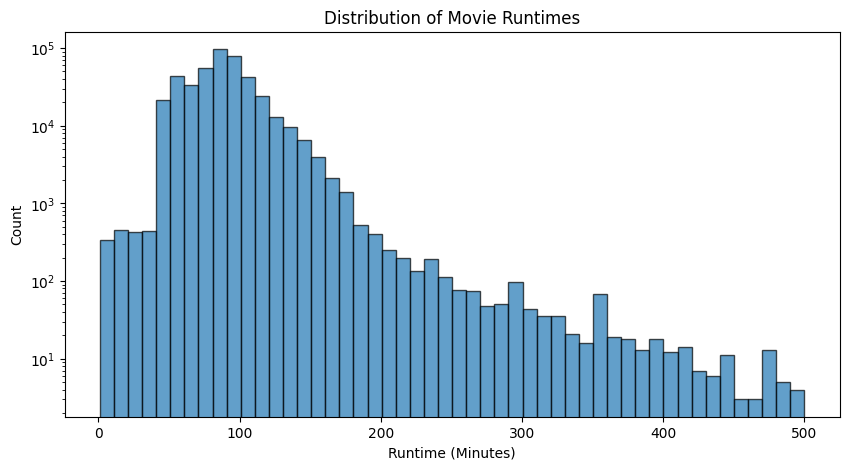

In [23]:
# Filter the DataFrame to include only movies
movies_df_filtered = movies_df.where(col('titleType') == 'movie')

# Convert the filtered DataFrame to a Pandas DataFrame
runtime_df = movies_df_filtered.select("runtimeMinutes").toPandas()

# Plot the distribution of movie runtimes
plt.figure(figsize=(10,5))
plt.hist(runtime_df['runtimeMinutes'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Count")
plt.title("Distribution of Movie Runtimes")
plt.yscale("log")
plt.show()

- The majority of movies have a runtime below **150 minutes**, with a sharp decline beyond that.
- The distribution has a **long right tail**, suggesting a small number of movies with extremely high runtimes.
- A **log scale** helps in revealing the presence of less common but very long movies.

#### **2. Box Plot for Outlier**

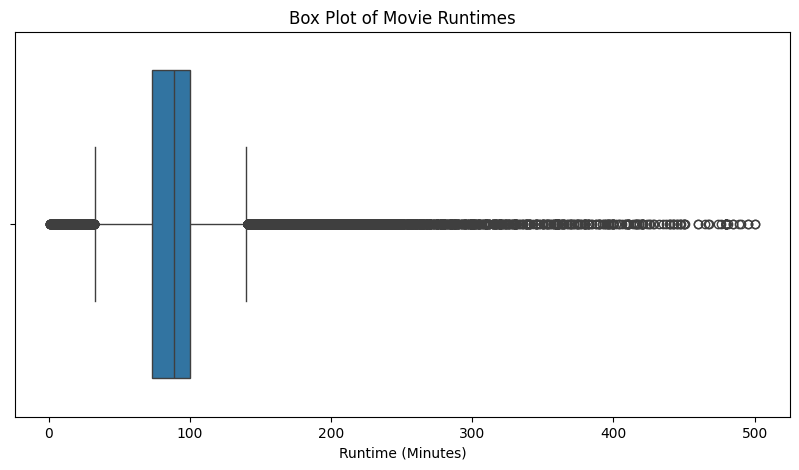

In [24]:
plt.figure(figsize=(10,5))

sns.boxplot(x=runtime_df['runtimeMinutes'])
plt.xlabel("Runtime (Minutes)")
plt.title("Box Plot of Movie Runtimes")
plt.show()

- The box plot confirms the **right-skewed nature** of the runtime distribution.
- The **median runtime** is relatively low, around **90–100 minutes**.
- **Significant outliers** exist, with many movies far beyond the upper whisker, some exceeding **300+ minutes**.
- The presence of extreme values suggests that filtering or capping outliers might be necessary for certain analyses.

#### **3. Runtimes by Title Type**

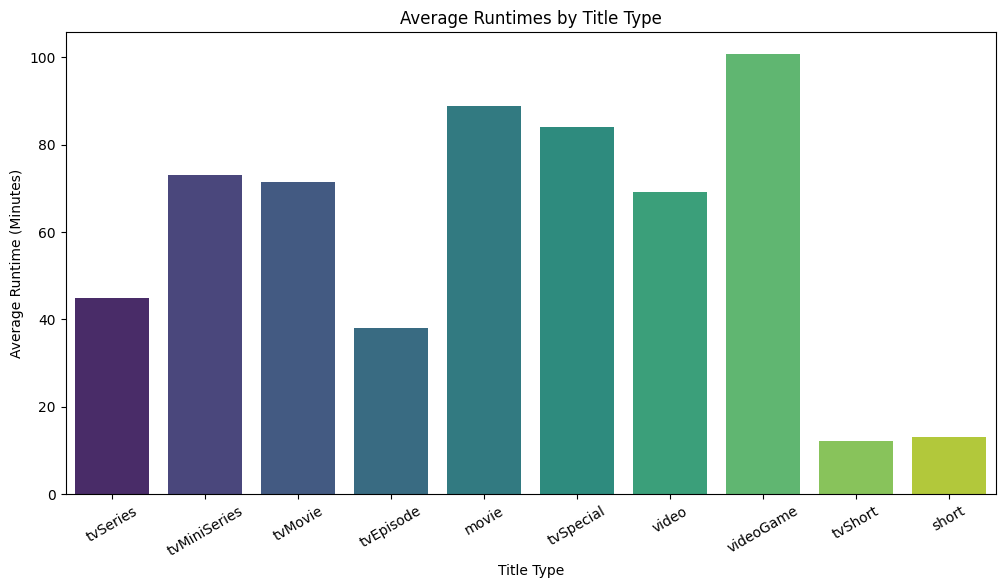

In [25]:
title_runtime_df = movies_df.groupBy("titleType").agg(
    F.avg("runtimeMinutes").alias("avg_runtime"),
    F.percentile_approx("runtimeMinutes", 0.25).alias("q1_runtime"),
    F.percentile_approx("runtimeMinutes", 0.50).alias("median_runtime"),
    F.percentile_approx("runtimeMinutes", 0.75).alias("q3_runtime")
).toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="titleType", y="avg_runtime", hue="titleType", data=title_runtime_df, palette="viridis")
plt.xticks(rotation=30)
plt.xlabel("Title Type")
plt.ylabel("Average Runtime (Minutes)")
plt.title("Average Runtimes by Title Type")
plt.show()

- **Movies and video games** have the highest average runtimes **(~100–110 minutes)**.
- **Shorts and TV episodes** have the lowest runtimes, typically under **30 minutes**.
- **TV series and miniseries** fall in the mid-range, with an average runtime of **40–70 minutes**, reflecting the typical structure of episodic content.
- **TV movies** also have a slightly lower runtime than theatrical movies, often around **80–90 minutes**, aligning with standard television broadcast formats.

In [26]:
movies_df.where(col("titleType") == 'tvPilot').show()

+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+
+------+---------+------------+-------------+-------+---------+-------+--------------+------+



### Correlation

#### **What is Correlation?**
Correlation tells us how two things are related. If one thing changes, does the other change too?

**Positive correlation (+1)**: When one thing increases, the other also increases.
- **Example**: The more you study, the higher your grades (hopefully!).

**Negative correlation (-1)**: When one thing increases, the other decreases.
- **Example**: The more time you spend on social media, the less time you have to study.

**No correlation (0)**: The two things have no connection.
- **Example**: The size of your shoes and your exam marks.

In [33]:
# To merge movie metadata with ratings, use inner join
imdb_df = movies_df.join(ratings_df, on="tconst", how="inner")
imdb_df.show(5)

# Show a few rows
imdb_df.printSchema()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0000001|    short|          Carmencita|          Carmencita|  false|     1894|   NULL|             1|   Documentary,Short|          5.7|    2129|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|  false|     1892|   NULL|             5|     Animation,Short|          5.6|     288|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|  false|     1892|   NULL|             5|Animation,Comedy,...|          6.4|    2165|
|tt0000004|    short|         Un bon bock|         Un bon bock|  false|     1892|   NULL|            12|  

Since the dataset contains multiple `title types` **(movies, TV series, video games, etc.)**, calculating correlation on the entire dataset may not give meaningful insights. Different title types have different distributions for `runtimeMinutes` and `averageRating`, so we should analyze them separately.

Why Should We Segment by titleType?
1. **Video games** typically have extremely high "runtime" values (they aren't comparable to movies).
2. **TV episodes** have shorter runtimes than movies but still get rated differently.
3. **Movies** follow a different runtime-rating pattern compared to TV series.

Since all these categories have different rating behaviors, lumping them together distorts correlation analysis.

**How Should We Fix This?**
Instead of calculating a single correlation for all title types combined, we should: ✅ Calculate correlation separately for each `titleType`

In [34]:
title_types = ['tvSeries', 'tvMiniSeries', 'tvMovie', 'tvEpisode', 'movie', 'tvSpecial', 'video', 'videoGame', 'tvShort', 'short']

for title in title_types:
    df_filtered = imdb_df.filter(col('titleType') == title)
    correlations = df_filtered.select(corr("averageRating", "runtimeMinutes")).collect()[0][0]
    print(f"Correlation for {title}: {correlations}")

Correlation for tvSeries: -0.026015555041185308
Correlation for tvMiniSeries: -0.004333508963161526
Correlation for tvMovie: -0.05581375486393078
Correlation for tvEpisode: 0.020658025708891088
Correlation for movie: 0.05549110617586464
Correlation for tvSpecial: -0.04817441160369518
Correlation for video: -0.018117592884826342
Correlation for videoGame: 0.23239091775052084
Correlation for tvShort: 0.043649871844318136
Correlation for short: 0.12200333097774148


✅ **Weak Negative Correlation (close to 0 but negative)**

- **tvSeries (-0.026)**
- **tvMiniSeries (-0.004)**
- **tvMovie (-0.055)**
- **tvSpecial (-0.048)**
- **video (-0.018)**

👉 These title types show almost no relationship between runtime and rating. A slightly negative correlation means longer runtimes might have slightly lower ratings, but the effect is negligible.

✅ **Weak Positive Correlation (close to 0 but positive)**

- **movie (0.055)**
- **tvShort (0.043)**
- **short (0.122)**

👉 Movies & Shorts show a slightly positive correlation, meaning longer ones tend to have slightly higher ratings. However, since the values are close to 0, the effect isn’t strong.

✅ **Moderate Positive Correlation**

- **videoGame (0.232)**

👉 This is the strongest correlation in the dataset.
For video games, longer playtime seems to increase ratings. 🎮 Makes sense because longer games often have more content, which players tend to appreciate.

✅ **Slight Positive Correlation for tvEpisodes**

- **tvEpisode (0.0206)**

👉 Very weak correlation, meaning runtime doesn’t affect ratings much for TV episodes.

#### **Final Thoughts**
- Most title types show almost no correlation, meaning runtime isn't a major factor in ratings for movies, TV shows, etc.
- Video games stand out—players prefer longer ones. 🎮
- Short films tend to have slightly higher ratings if they’re longer.

### Genre-Based Analysis

In the IMDb dataset, the `genres` column can have multiple genres per title, separated by commas (e.g., `"Action,Adventure,Sci-Fi"`).
We need to split these values and count each genre separately.
- Join the exploded genre dataset with ratings.
- Group by genre.
- Calculate the average rating for each genre.

Instead of mixing all title types, we’ll break down the **genre-based analysis** separately for each `titleType`.

In [67]:
# Explode the genre column (split multiple genres into separate rows)
genre_df = imdb_df.withColumn("genres", explode(split(col('genres'), ",")))

# Group by titleType and genre, then calculate average rating
genre_rating_df = (genre_df.groupBy("titleType", "genres")
                .agg(avg("averageRating").alias("avg_rating"),  # Calculate average rating
                     count("*").alias("genre_count") # Count how many times each genre appears
                    )
                .filter(col("genre_count") >= 500) # Filter out rare genres (less than 500 titles)
                .orderBy("titleType", col("avg_rating").desc()) # Sort by titleType & rating
               )

# Shiw the top results
genre_rating_df.show(50)

+---------+-----------+------------------+-----------+
|titleType|     genres|        avg_rating|genre_count|
+---------+-----------+------------------+-----------+
|    movie|       News| 7.238914027149312|        663|
|    movie|Documentary| 7.213967403811962|      47797|
|    movie|  Biography| 6.943367923558997|       9733|
|    movie|    History| 6.787112447940788|       8644|
|    movie|      Music| 6.745878977569174|       7668|
|    movie|      Sport| 6.613784067085965|       3816|
|    movie|  Film-Noir| 6.457208765859284|        867|
|    movie|        War| 6.379916115502501|       6199|
|    movie|  Animation|6.3251551043429135|       5319|
|    movie|      Drama| 6.221650671211041|     133788|
|    movie|     Family|6.1685202968136235|      11455|
|    movie|    Musical| 6.151162790697696|       6192|
|    movie|         \N|6.1014369693011465|       6124|
|    movie|    Romance| 6.087961584050145|      32903|
|    movie|      Crime|5.9731383381262155|      26428|
|    movie

#### 1. **Find the most popular genres – Count the number of titles per genre.**
- Count the number of titles per genre to identify the most common genres.

In [96]:
genre_count_df = genre_df.groupBy("genres").count().orderBy(col("count").desc())
genre_count_df.show()

+-----------+------+
|     genres| count|
+-----------+------+
|      Drama|387699|
|     Comedy|324750|
|      Short|149285|
|Documentary|144616|
|     Action|129588|
|  Animation|125882|
|      Crime|121301|
|  Adventure|118999|
|    Romance| 84984|
|     Family| 75839|
|    Mystery| 55476|
|     Horror| 53237|
| Reality-TV| 51867|
|   Thriller| 49595|
|    Fantasy| 44478|
|      Music| 32576|
|    History| 31077|
|     Sci-Fi| 27571|
|  Biography| 23146|
|  Talk-Show| 21364|
+-----------+------+
only showing top 20 rows



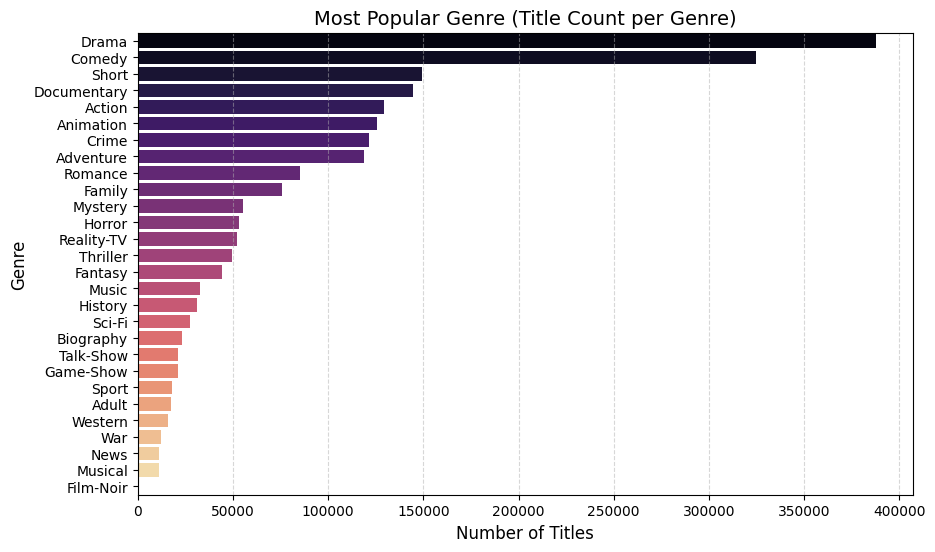

In [110]:
genre_popularity_df = (genre_df.groupBy('genres')
                       .agg(count("*").alias("genre_count"))
                       .filter((col("genre_count") >= 500) & ((col("genres") != "\\N")))
                       .orderBy(desc("genre_count"))
                      )

# Convert to Pandas for visualization
genre_popularity_df = genre_popularity_df.toPandas()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="genre_count", y="genres", hue="genres", data=genre_popularity_df, palette="magma")

# Labels & title
plt.xlabel("Number of Titles", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.title("Most Popular Genre (Title Count per Genre)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show Plot
plt.show()

**Observations**:
- **Drama** is the most common genre, followed by Comedy and Short films.
- **Documentaries** are also quite frequent, ranking 4th.
- Genres like **Action**, **Animation**, and **Crime** have significant numbers as well.
- **Talk-Show** and **Reality-TV** make it to the top 20, showing a substantial presence.

#### **Average rating per genre – Which genres get the highest ratings?**

**Next Steps:**
1. **Filter by Title Type**
- Create subsets of the data based on `titleType` (e.g., `movie`, `tvSeries`, `tvMiniSeries`, etc.).

2. **Calculate Average Rating Per Genre (For Each Title Type)**
- Group by `genre` and calculate the mean averageRating separately for each `titleType`.

3. **Filter Out Genres with Low Representation**
- Set a threshold (e.g., only consider genres with **at least 500 titles**) to ensure reliable insights.

4. **Visualize**
- Plot **genre-wise average ratings** separately for movies, TV shows, etc.
- We'll use **bar charts** for easier interpretation.

We need to **filter it specifically for movies** before visualization.

In [92]:
# Filter only for movies
movie_genre_rating_df = genre_rating_df.filter((col("titleType") == "movie") & (col("genres") != "\\N"))

The reason we filter genres with fewer than **500 occurrences** is to ensure statistical **reliability and meaningful insights**. Here's why:

1. **Avoiding Misleading Averages**
- For example, if a **rare genre** has only 2 movies with ratings **9.5 and 2.0**, its average rating will be **(9.5 + 2.0) / 2 = 5.75**, which isn't a true representation.
- If a genre appears in very few movies (e.g., only 5 or 10 titles), **its average rating may be skewed** by just a few extreme values (very high or low ratings).

2. **Ensuring Statistical Significance**
- A larger sample size (more movies per genre) means more **stable and reliable averages**.
- A genre with **thousands of movies** will have a more **trustworthy rating trend** compared to a genre with just **a handful** of titles.

3. **Focusing on Popular Genres for Better Insights**
- IMDb has **hundreds of niche genres**, many of which have **very few titles**.
- By filtering out **low-count genres**, we focus on **widely recognized categories** that give **better visualization and analysis**.

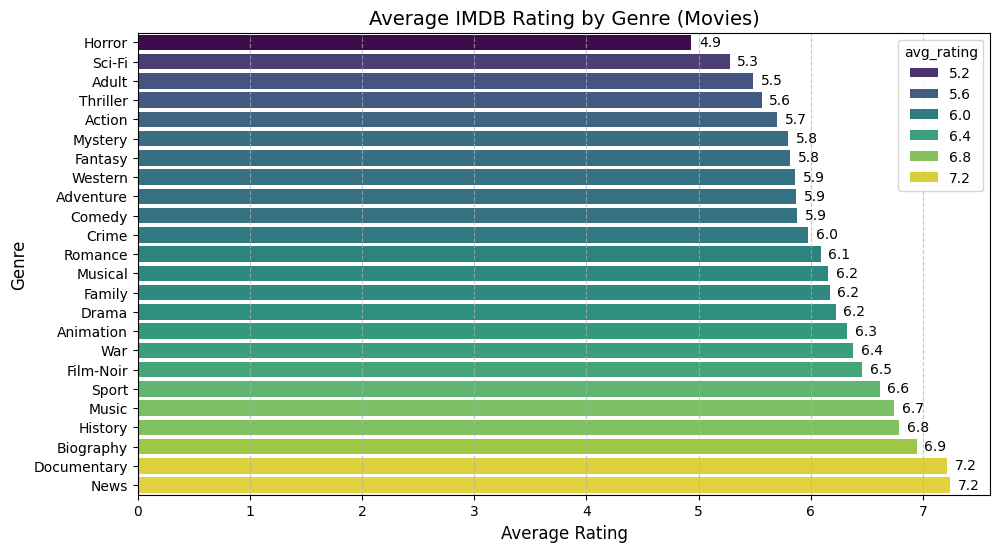

In [93]:
# Convert to Pandas for visualization
movie_genre_rating_df = movie_genre_rating_df.toPandas()

# Sort genres by average rating
movie_genre_rating_df = movie_genre_rating_df.sort_values(by="avg_rating", ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(11,6))
ax = sns.barplot(x="avg_rating", y="genres", hue="avg_rating", data=movie_genre_rating_df, palette="viridis")

for index, value in enumerate(movie_genre_rating_df["avg_rating"]):
    ax.text(value + 0.07, index, f"{value:.1f}", va="center", fontsize=10, color="black")

# Labels and title
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.title("Average IMDB Rating by Genre (Movies)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

### Observations:
- **Documentary** and **News** movies have the highest average ratings (~7.2).
- **Horror** movies have the lowest average rating (~5.0), which is a common trend due to audience expectations and critical reception.
- **Sci-Fi, Thriller, and Action** movies are clustered around the lower ratings.
- **Drama, Biography, and History** movies tend to have higher ratings, possibly because they focus on storytelling rather than mass entertainment.

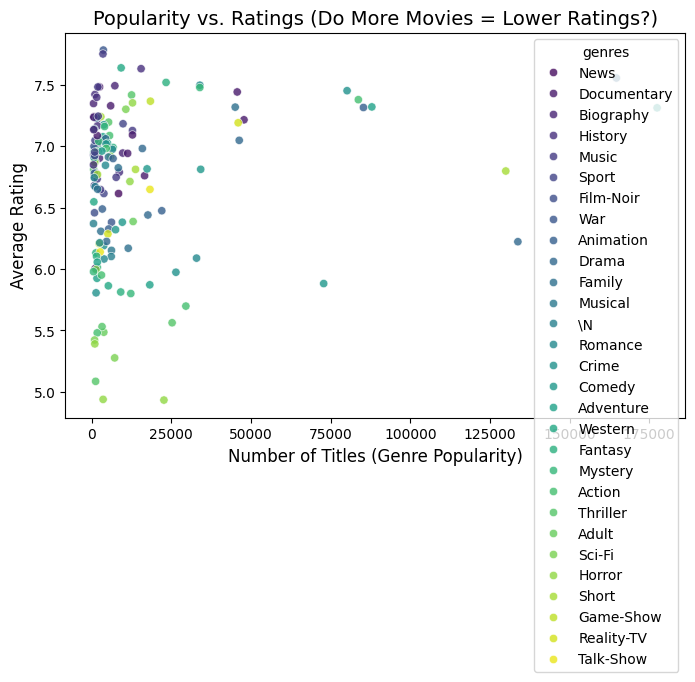

In [112]:
# Scatter plot: Genre count vs. Avg rating
plt.figure(figsize=(8,5))
sns.scatterplot(x="genre_count", y="avg_rating", data=title_genre_df, hue="genres", palette="viridis", alpha=0.8)

# Labels & title
plt.xlabel("Number of Titles (Genre Popularity)", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.title("Popularity vs. Ratings (Do More Movies = Lower Ratings?)", fontsize=14)

# Show plot
plt.show()


In [75]:
df_pandas = genre_rating_df

# Set figure size
plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(
    x=df_pandas["genre_count"], 
    y=df_pandas["avg_rating"], 
    hue=df_pandas["avg_rating"],  # Color based on rating
    palette="viridis", 
    size=df_pandas["avg_rating"],  # Size based on rating
    sizes=(20, 200),  # Adjust point size range
    alpha=0.75  # Transparency
)

# Labels and title
plt.xlabel("Number of Movies in Genre")
plt.ylabel("Average IMDB Rating")
plt.title("Genre Popularity vs. Average Rating")
plt.xscale("log")  # Log scale for better visualization if needed
plt.legend(title="Avg Rating", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.show()

PySparkTypeError: [NOT_ITERABLE] Column is not iterable.

<Figure size 1200x600 with 0 Axes>

In [ ]:
genre_df.show()

In [ ]:
filtered_df.where((col('startYear') > 1800) & (col('startYear') < 1900 )).groupBy('titleType', "startYear").count().orderBy(col("startYear")).show(50)